In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math
from sklearn.datasets import load_iris
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings("ignore")
from analysis_functions import *

def create_task_behaviour_session_wise(behaviour_list,colapse_behaviour,object_fixed,timeline_list):
    
    # define targets of behaviour according to protocol (random, overlapping and stable)
    id_target = [0,1,2,3,4] # 0: unlabeled, 1:resting, 2:Navigation, 3: Obj1, 4:Obj2, 5:Run1, 6:Run2
    
    print('REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS')
    if colapse_behaviour == 0 : # RANDOM
        for day in range(4):
            for trial in range(5):
                behaviour_trial = behaviour_list[int(timeline_list[day*5+2*trial]):int(timeline_list[day*5+2*trial+1])]
                objects = np.unique(behaviour_trial)
                if len(objects)>4:
                    selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
                    index0 = np.where(behaviour_trial==objects[selected_object])[0]
                    index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-4], behaviour_trial!=objects[selected_object]))[0]
                    index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-3], behaviour_trial!=objects[selected_object]))[0]
                    behaviour_trial[index0] = 3
                    behaviour_trial[index1] = 4
                    behaviour_trial[index2] = 4            

                    index0 = np.where(behaviour_trial==objects[selected_object]+4)[0]
                    index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-2], behaviour_trial!=objects[selected_object]+4))[0]
                    index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-1], behaviour_trial!=objects[selected_object]+4))[0]
                    behaviour_trial[index0] = 3
                    behaviour_trial[index1] = 4
                    behaviour_trial[index2] = 4 

                    behaviour_list[int(timeline_list[day*5+2*trial]):int(timeline_list[day*5+2*trial+1])]= behaviour_trial


    if colapse_behaviour == 1 : #OVERLAPPING
        behaviour_list[np.where(behaviour_list == object_fixed)[0]] = 100
        behaviour_list[np.where(np.logical_and(behaviour_list>=3, behaviour_list<=6))[0]] = 4
        behaviour_list[np.where(behaviour_list == 100)[0]] = 3        
        behaviour_list[np.where(behaviour_list == object_fixed +4)[0]] = 200      
        behaviour_list[np.where(np.logical_and(behaviour_list>=7, behaviour_list<=10))[0]] = 4
        behaviour_list[np.where(behaviour_list == 200)[0]] = 3


    if colapse_behaviour == 2: #STABLE
        for day in range(4):
            for trial in range(5):
                behaviour_trial = behaviour_list[int(timeline_list[day*5+2*trial]):int(timeline_list[day*5+2*trial+1])]
                objects = np.unique(behaviour_trial)
                if len(objects)>4:
                    selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
                    index0 = np.where(behaviour_trial==objects[selected_object])[0]
                    index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-4], behaviour_trial!=objects[selected_object]))
                    index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-3], behaviour_trial!=objects[selected_object]))
                    behaviour_trial[index0] = 3
                    behaviour_trial[index1] = 4
                    behaviour_trial[index2] = 4      

                    index0 = np.where(behaviour_trial==objects[selected_object]+4)[0]
                    index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-2], behaviour_trial!=objects[selected_object]+4))
                    index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-1], behaviour_trial!=objects[selected_object]+4))
                    behaviour_trial[index0] = 3
                    behaviour_trial[index1] = 4
                    behaviour_trial[index2] = 4 
                    
                    behaviour_list[int(timeline_list[day*5+2*trial]):int(timeline_list[day*5+2*trial+1])]= behaviour_trial

    return

def create_corners_occupation_session_wise(behaviour_list, corners_list, speed_list):
    navigation_list = [] 
    exploration_list = []

    speed = signal.medfilt(speed_list,9)
    # select the corners that are being explored when the animal is doing an exploratory task
    explorating_object = np.zeros_like(corners_list)
    explorating_object[np.where(behaviour_list==4)[0]] = corners_list[np.where(behaviour_list==4)[0]]
    explorating_object[np.where(behaviour_list==3)[0]] = corners_list[np.where(behaviour_list==3)[0]]

    navigation_corner = np.zeros_like(corners_list)
    for corner in [1,2,3,4]:
        # create a vector that contains zeros everywhere but corner ID when the animal is navigation at that position with out an object
        navigations_at_corner = np.logical_and(explorating_object==0,corners_list==corner)
        navigation_corner[navigations_at_corner] = corner

        navigation_list.append(navigation_corner)
        exploration_list.append(explorating_object)
        
    return navigation_list, exploration_list


In [2]:
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 10  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 2           ## alignment version, version 3 is trial wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version
binary = True

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 1                 ## value of resampling
period = int(5 * sf / re_sf)
period_resting = period *50
N_SHUFFLINGS = 50
colorcodes = ['Greys','PuBu', 'YlOrRd','Reds','Blues','Oranges','Greens']


In [3]:
mouse_vector = [56165, 56166, 32363, 32364, 32365, 32366, 411857, 401714]

mouse = 411857 
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/registered/'

session_now = 1

print('SESSION ====', session_now)

file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_session_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/registered/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_parameters = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_parameters/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/center_of_mass/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/registered/'

objects_position_file = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/occupied_corners/' + 'mouse_'+f'{mouse}'+'_session_'+f'{session_now}'+'.npy'
occupied_corners = np.load(objects_position_file)
task,colapse_behaviour,object_fixed,fixed,labels,colornames = mouse_properties(mouse = mouse, session_now = session_now)

SESSION ==== 1


In [4]:
activity_list,timeline_list,behaviour_list,corners_list,parameters_time,parameters_list,parameters_list2, speed_list= load_data_session(mouse, session_now,re_sf,file_directory, timeline_file_dir, behaviour_dir, behaviour_dir_parameters, objects_dir)
create_task_behaviour_session_wise(behaviour_list,colapse_behaviour,object_fixed,timeline_list)
# figure, axes = plt.subplots()

# C_0 = activity_list.copy()
# size = 100
# for i in range(size):
#     norm = (C_0[i,:]-np.min(C_0[i,:]))/(np.max(C_0[i,:])-np.min(C_0[i,:]))
#     plt.plot(norm+i)

# figure.set_size_inches([50,size])
# figure.savefig(figure_path+'calcium_traces_registered.png')

LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR
neural shape =  (571, 135118) beh shape(135118,)
REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS


In [5]:
data_transformation = transform_neural_data_session_wise(activity_list, behaviour_list,parameters_time,parameters_list,parameters_list2,timeline_list)    


REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS


In [7]:
navigation_list, exploration_list = create_corners_occupation_session_wise(behaviour_list, corners_list, speed_list)
combination_corners = []
for i in range(len(navigation_list)):
    combination_corners.append(navigation_list[i] + 10*exploration_list[i])
id_target_combination = [1,2,3,4,10,20,30,40]

In [27]:

data_transformation.lda.shape

(8, 135118)

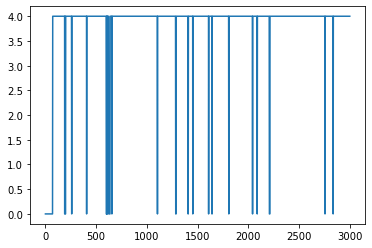

In [32]:
plt.plot(behaviour_list[0:3000])

In [29]:
def create_list(data,timeline):
    
    data_list = []
    for i in range(len(timeline)-1):
        index1 = int(timeline[i])
        index2 = int(timeline[i+1])
        data_list.append(data[:,index1:index2])
    
    return data_list

def create_data_transformation_list(data_transformation,timeline):
    
    data_pca = []
    variance = []
    data_cca0 = []
    data_cca1 = []
    data_cca2 = []
    data_lda = []
    data_trials = []
    for i in range(len(timeline)-1):
        index1 = int(timeline[i])
        index2 = int(timeline[i+1])
        data_pca.append(data_transformation.pca[:,index1:index2])
        variance.append(data_transformation.variance_ratio)
        data_cca0.append(data_transformation.cca_time[:,index1:index2])
        data_cca1.append(data_transformation.cca_allo[:,index1:index2])
        data_cca2.append(data_transformation.cca_ego[:,index1:index2])
        data_lda.append(data_transformation.lda[:,index1:index2])
        data_trials.append(i)
        

    data_transformation = namedtuple('data_transformation', ['pca','variance_ratio','cca_time','cca_allo','cca_ego','lda','trials'])

    return data_transformation(data_pca,variance,data_cca0,data_cca1,data_cca2,data_lda,data_trials)
    
def create_trials(activity_list,data_transformation,combination_corners,timeline_list):
    
    activity = create_list(activity_list,timeline_list)
    
    data_transformation_list =  create_data_transformation_list(data_transformation,timeline_list)
    
    data_list = []
    for i in range(len(timeline_list)-1):
        index1 = int(timeline_list[i])
        index2 = int(timeline_list[i+1])
        data_list.append(combination_corners[index1:index2])
        
    return activity, data_transformation_list, data_list
    

In [30]:
activity1, data_transformation1, combination_corners1 = create_trials(activity_list,data_transformation,combination_corners,timeline_list)
   

In [38]:
len(combination_corners1)

42

In [32]:
metric_use = 'euclidean'
trial_activity, trial_activity_shuffle, evnets_id, distance = compute_representational_distance_measures_all_to_all(activity1,data_transformation1,period,combination_corners1,id_target_combination,N_SHUFFLINGS,[1],metric = metric_use)
      
    

CREATE LIST THAT SAVES ALL THE EVENTS IN A DAY AND CONTAINS ONSET OF VISITS


AttributeError: 'list' object has no attribute 'shape'

In [18]:
    
metric_use = 'euclidean'
trial_activity, trial_activity_shuffle, evnets_id, distance = compute_representational_distance_measures_all_to_all(activity1,data_transformation,period,combination_corners1,id_target_combination,N_SHUFFLINGS,data_transformation.trials,metric = metric_use)
    
output_directory = '/home/melisamc/Documentos/neural_analysis/data/mean_representational_distance/distance_matrix/'
distance_matrix_file = output_directory + 'distance_matrix_mouse_' + f'{mouse}' +'_session_'+ f'{session_now}' +'.daily_zscored.npy'
np.save(distance_matrix_file,distance)
 

AttributeError: 'data_transformation' object has no attribute 'trials'

In [ ]:
   
#     ##### TRIAL TRANSFORMATIONS ####
    activity_list_trial,timeline_list_trial,behaviour_list_trial,corners_list_trial,parameters_time_trial,parameters_list_trial,parameters_list2_trial, speed_list_trial,trial_list,tracking_list_trial = load_data_trial(mouse, session_now,decoding_v, motion_correction_v, alignment_v, equalization_v,source_extraction_v,component_evaluation_v, re_sf,file_directory, timeline_file_dir, behaviour_dir, behaviour_dir_parameters, tracking_dir, objects_dir,binary = False)
    data_transformation_trial = transform_neural_data(activity_list_trial, behaviour_list_trial,parameters_time_trial,parameters_list_trial,parameters_list2_trial,timeline_list_trial,trial_list)
    #data_transformation_trial = transform_neural_data(activity_list, behaviour_list,parameters_time,parameters_list,parameters_list2,timeline_list,day_list,trial_flag = True)
    
    create_task_behaviour_trial(behaviour_list_trial,colapse_behaviour,object_fixed,timeline_list_trial,data_transformation_trial.trials)    
    navigation_list_trial, exploration_list_trial = create_corners_occupation(behaviour_list_trial, corners_list_trial, speed_list_trial,data_transformation_trial.trials)   
    
    combination_corners_trial = corners_list_trial
    id_target_combination = [1,2,3,4]
    
    trial_activity, trial_activity_shuffle, events_id, distance = compute_representational_distance_measures_all_to_all(activity_list_trial,data_transformation_trial,period,combination_corners_trial,id_target_combination,N_SHUFFLINGS,data_transformation_trial.trials,metric = metric_use,trial_flag = True)
    output_directory = '/home/melisamc/Documentos/neural_analysis/data/mean_representational_distance/distance_matrix/'
    distance_matrix_file = output_directory + 'distance_matrix_mouse_' + f'{mouse}' +'_session_'+ f'{session_now}' +'_trial_based_zscored_1.npy'
    np.save(distance_matrix_file,distance)
    
    data_transformation_trial_2 = transform_neural_data(activity_list, behaviour_list,parameters_time,parameters_list,parameters_list2,timeline_list,day_list,trial_flag = True)
    
    create_task_behaviour_trial(behaviour_list_trial,colapse_behaviour,object_fixed,timeline_list_trial,data_transformation_trial.trials)    
    navigation_list_trial, exploration_list_trial = create_corners_occupation(behaviour_list_trial, corners_list_trial, speed_list_trial,data_transformation_trial.trials)   
    
    combination_corners_trial = corners_list_trial
    id_target_combination = [1,2,3,4]
    
    trial_activity, trial_activity_shuffle, events_id,distance = compute_representational_distance_measures_all_to_all(activity_list_trial,data_transformation_trial_2,period,combination_corners_trial,id_target_combination,N_SHUFFLINGS,data_transformation_trial.trials,metric = metric_use,trial_flag = True)
    output_directory = '/home/melisamc/Documentos/neural_analysis/data/mean_representational_distance/distance_matrix/'
    distance_matrix_file = output_directory + 'distance_matrix_mouse_' + f'{mouse}' +'_session_'+ f'{session_now}' +'_trial_based_zscored_2.npy'
    np.save(distance_matrix_file,distance)
    
    